### This notebook demonstrates how to apply a trained model for inference of an image

In [1]:
import os
import numpy as np
import cv2

import matplotlib.pyplot as plt
%matplotlib inline

### Select model mode:

- `local`: download the .h5 file from checkpoint folder to local and load it locally for inference. This requires Tensorflow installed locally.
- `sagemaker`: call the deployed model endpoint on Sagemaker

In [2]:
model_mode = "local"

if model_mode == "local":
    import tensorflow as tf
    
    # the following 5 lines configures local TF environment. you may need to change it according to your device.
    from tensorflow.compat.v1 import ConfigProto, InteractiveSession
    os.environ["CUDA_VISIBLE_DEVICES"] = "1"
    config = ConfigProto()
    config.gpu_options.allow_growth = True
    session = InteractiveSession(config=config)
    
    # load model from a downloaded .h5 file. 
    # e.g. S3://st-crayon-dev/tf-checkpoints/resnet50-acrlg-224x224-896x896-random-64-8x4-80-32-32_2020-09-02-19-28-03-728086/resnet50.025.h5
    model = tf.keras.models.load_model("./data/model/resnet50.025.h5")
else:
    import sagemaker
    import boto3
    from sagemaker.tensorflow import TensorFlowPredictor
    
    boto_session = boto3.Session(profile_name="crayon-site") # specify your local aws profile
    sagemaker_session = sagemaker.Session(boto_session)
    
    endpoint_name = 'resnet50-acrlg-224x224-896x896-random-6-2020-09-02-21-07-38-621'
    model = TensorFlowPredictor(endpoint_name, sagemaker_session=sagemaker_session)

/home/tailaiw/work/site/ai-automation/venv/lib/python3.7/site-packages/tensorflow/python/keras/layers/core.py:1045: UserWarning: models is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)


### Setup crop size and input size

This is supposed to be the same as how they are set when the model was trained.

1. Cut the image into crops of `crop_size`
2. Rescale all crops to model input of `input_size`
3. Apply the model to all crops and get mask in `input_size`
4. Rescale all mask back to `crop_size`
5. Integrate all crop mask back into an image mask

In [3]:
crop_size = (896, 896)
input_size = (224, 224)

batch_size = 16

### Load you image and apply to it

In [4]:
img_file = "/home/tailaiw/work/site/s3/20-OR-1086/Mapping/PDX_14_mapping_1.jpg"

img = cv2.cvtColor(cv2.imread(img_file, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
H, W, _ = img.shape

# overlap_factor controls amount of crop overlap.
# 2 is minimal, greater value returns smoother mask but runs slower, 3 is good trade-off in general
overlap_factor = 3

crops = []
for i in np.linspace(0, H - crop_size[1], int(H / crop_size[1]) * overlap_factor):
    for j in np.linspace(0, W - crop_size[0], int(W / crop_size[0]) * overlap_factor):
        crop = img[
            int(i) : int(i) + crop_size[1], int(j) : int(j) + crop_size[0], :,
        ]
        crops.append(crop)

In [5]:
X = np.stack([cv2.resize(crop, input_size) for crop in crops], axis=0)

if model_mode == "local":
    Y = model.predict(X, batch_size=batch_size)
else:
    # we manually cut X into "batches" and make multiple endpoint calls, as we found the endpoint may raise pipeline error if the input is too big
    Y = np.vstack(
        [
            np.array(model.predict(X[i : i + batch_size, :, :, :])["predictions"])
            for i in range(0, len(X), batch_size)
        ]
    )

In [6]:
mask = np.zeros((H, W, 6))
crop_count = np.zeros((H, W))
counter = 0
for i in np.linspace(0, H - crop_size[1], int(H / crop_size[1]) * overlap_factor):
    for j in np.linspace(0, W - crop_size[0], int(W / crop_size[0]) * overlap_factor):
        crop_mask = cv2.resize(Y[counter, :, :, :], crop_size)
        mask[
            int(i) : int(i) + crop_size[1], int(j) : int(j) + crop_size[0], :,
        ] += crop_mask
        crop_count[int(i) : int(i) + crop_size[1], int(j) : int(j) + crop_size[0]] += 1
        counter += 1
confidence = np.max(mask, axis=-1) / crop_count
mask = np.argmax(mask, axis=-1).astype(np.uint8)

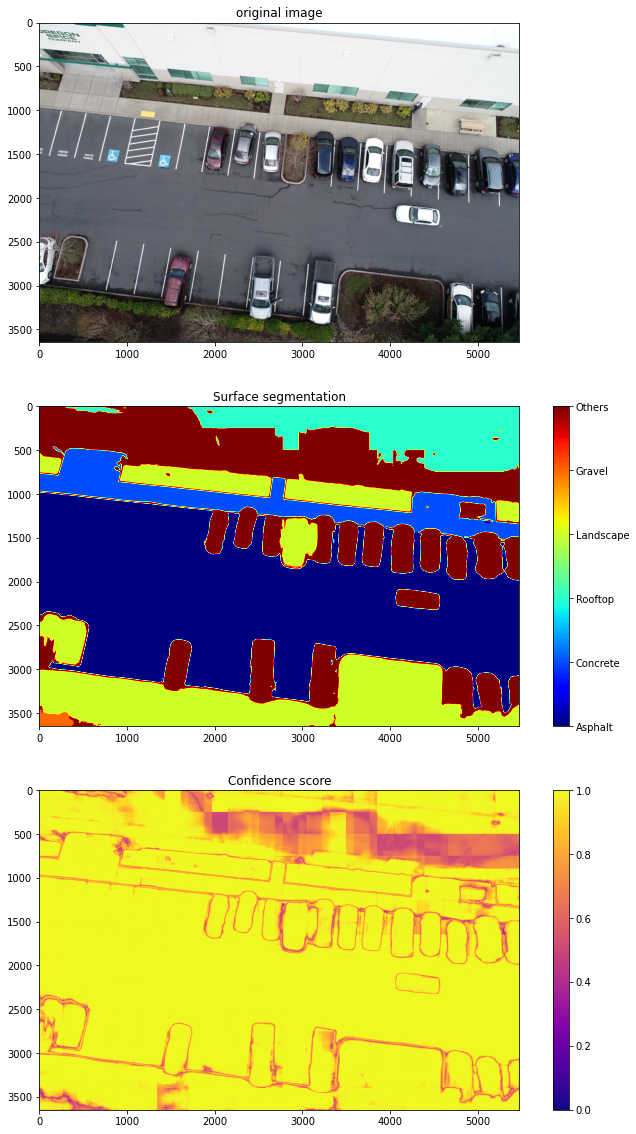

In [7]:
fig, ax = plt.subplots(nrows=3, sharey=True, figsize=(12, 20))
m0 = ax[0].imshow(img)
ax[0].set_title("original image")
cax0 = fig.colorbar(m0, ax=ax[0])
cax0.remove()

m1 = ax[1].imshow(mask,  cmap="jet")
ax[1].set_title("Surface segmentation")
cax = fig.colorbar(m1, ax=ax[1])
cax.set_ticks([0, 1, 2, 3, 4, 5])
cax.set_ticklabels(["Asphalt", "Concrete", "Rooftop", "Landscape", "Gravel", "Others"])

m2 = ax[2].imshow(confidence, vmin=0.0, vmax=1.0, cmap="plasma")
ax[2].set_title("Confidence score")
cax2 = fig.colorbar(m2, ax=ax[2])